<a href="https://colab.research.google.com/github/lucamatteucci10/BA820-team-10/blob/main/Project%20820/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data_project_820/Tweet_data.csv', encoding='ISO-8859-1', names=['polarity', 'id', 'date', 'query', 'user', 'text'])
df.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.shape

(1600000, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


It seems that there are no null values, but let's just double check to make sure.

In [ ]:
df.isna().sum()

polarity    0
id          0
date        0
query       0
user        0
text        0
dtype: int64

There are no null values so let's look at the distribution for the numerical columns.

In [ ]:
df.describe()

,polarity,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [ ]:
df.duplicated().sum()

0

In [ ]:
df['polarity'].unique()

array([0, 4])

In [ ]:
df['polarity'] = df['polarity'].replace({4: 1})

In [ ]:
df['user'].nunique()

659775

In [ ]:
df.describe()

,polarity,id
count,1600000.0,1.600000e+06
mean,0.5,1.998818e+09
std,0.5,1.935761e+08
min,0.0,1.467810e+09
25%,0.0,1.956916e+09
50%,0.5,2.002102e+09
75%,1.0,2.177059e+09
max,1.0,2.329206e+09


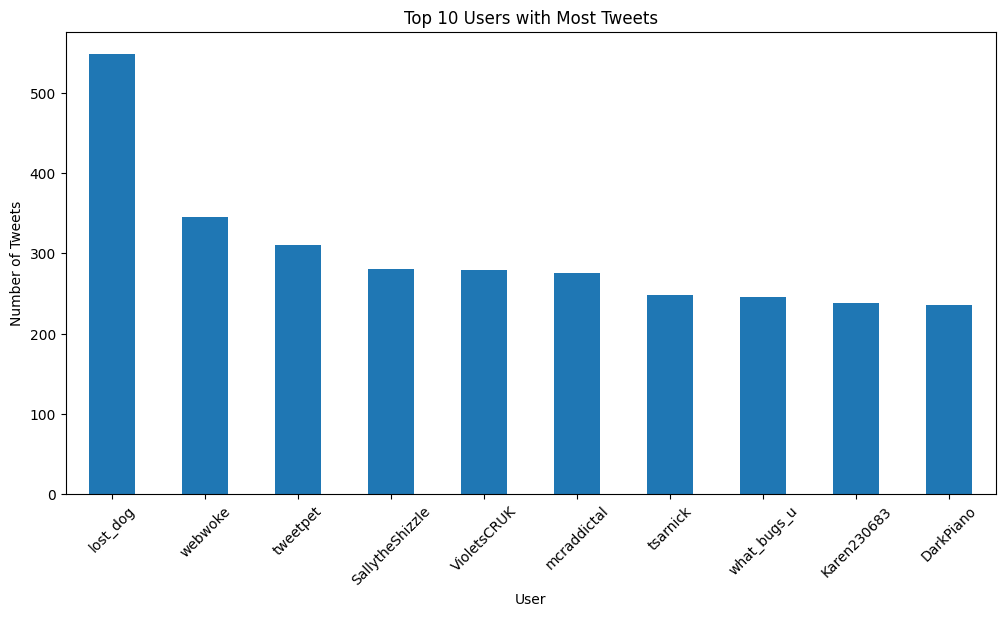

In [ ]:
top_users = df['user'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
top_users.plot(kind='bar')
plt.xlabel('User')
plt.ylabel('Number of Tweets')
plt.title('Top 10 Users with Most Tweets')
plt.xticks(rotation=45)
plt.show()

In [ ]:
top_users = df['user'].value_counts().nlargest(10).index
top_users_df = df[df['user'].isin(top_users)]
counts = top_users_df.groupby(['user', 'polarity']).size().unstack(fill_value=0)
counts['total_tweets'] = counts.sum(axis=1)
counts = counts.sort_values(by='total_tweets', ascending=False)
plt.figure(figsize=(12, 6))
counts.drop('total_tweets', axis=1).plot(kind='bar', stacked=True)
plt.xlabel('User')
plt.ylabel('Number of Tweets')
plt.title('Number of Positive and Negative Tweets by Top 10 Users')
plt.xticks(rotation=45)
plt.legend(title='Polarity', labels=['Positive', 'Negative'])
plt.show()

In [ ]:
df_new = pd.DataFrame(df)
df_new['text'] = df['text'].str.lower()
df_new['text'] = df['text'].str.replace(r'[^\w\s]', '')
df_new.head()

Check if there are tweets with URLs.

In [ ]:
http_texts = df[df['text'].str.startswith('http')]

print(http_texts)

In [ ]:
df_new = df_new[~df_new['text'].str.startswith('http')]

In [ ]:
df_new.info()

Check if there are texts with hashtags

In [ ]:
texts_with_hashtag = df_new[df_new['text'].str.startswith('#')]

print(texts_with_hashtag)

In [ ]:
print(df_new)

In [ ]:
#Tokenization
from nltk.tokenize.casual import TweetTokenizer
import nltk
nltk.download('punkt')

tokenized = [TweetTokenizer().tokenize(t) for t in df_new['text']]

tokenized

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
tokenizer = TweetTokenizer().tokenize
cv = CountVectorizer(tokenizer=tokenizer, stop_words='english')
X = cv.fit_transform(df_new['text'])

print('number of `tokens`', len(cv.vocabulary_))
print('Vocabulary:', cv.get_feature_names_out())

In [ ]:
tokenized_df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names_out())
print(tokenized_df.head())